# 2.1 音声ファイルを開いてみよう

In [1]:
import wave
import pyroomacoustics as pa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CMU ARCTIC Corpusをカレントディレクトリにダウンロード
pa.datasets.CMUArcticCorpus(basedir="./CMU_ARCTIC", download=True, speaker=["aew", "axb"])

In [3]:
# 読み込むサンプルファイル
sample_wave_file = "./arctic_a0001.wav"

In [4]:
# ファイルを読み込む
with wave.open(sample_wave_file, "rb") as wav:

    print("サンプリング周波数[Hz]: ", wav.getframerate())
    print("サンプルサイズ[Byte]: ", wav.getsampwidth())
    print("サンプル数: ", wav.getnframes())
    print("チャンネル数: ", wav.getnchannels())

    # PCM形式の波形データを読み込み
    data = wav.readframes(wav.getnframes())

サンプリング周波数[Hz]:  16000
サンプルサイズ[Byte]:  2
サンプル数:  62081
チャンネル数:  1


* 音声ファイルの種類
  * 元の音声波形を圧縮して保存するファイル
  * 無圧縮ファイル：PCM (Pulse Code Modulation) 方式、サンプリング周波数に従い一定間隔で測定された音声信号が所定のビット数で記録されている

In [5]:
# dataを2バイトの数値列に変換
data = np.frombuffer(data, dtype=np.int16)

# dataの値を2バイトの変数が取り得る値の最大値で正規化
data = data / np.iinfo(np.int16).max

# x軸の値(秒数の計算): 全データ数/サンプリング周波数
x = np.array(range(wav.getnframes())) / wav.getframerate()

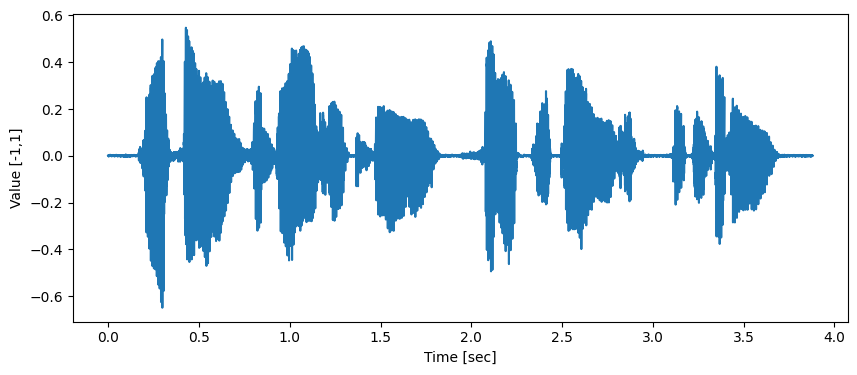

In [6]:
# 音声データをプロットする
plt.figure(figsize=(10, 4))

# 軸のラベル
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1,1]")

# データをプロット
plt.plot(x, data)

* 非定常な信号：信号の統計的性質が時間ごとに大きく変化する信号（上）
* 定常な信号：信号の性質があまり変化しない信号（e.g. 白色雑音）（下）

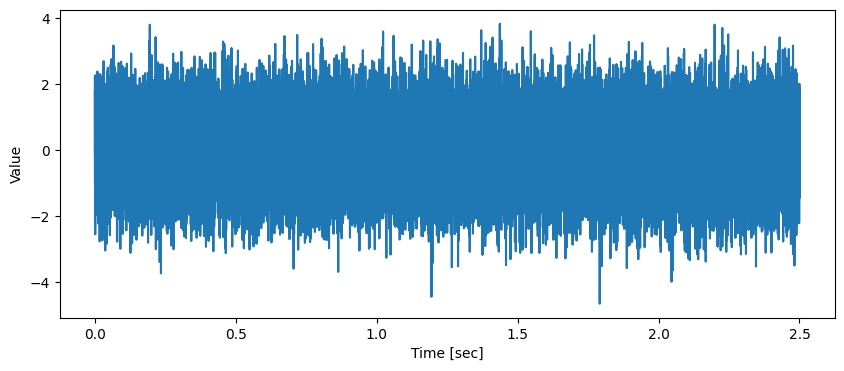

In [7]:
n_sample = 40000
sample_rate = 16000
np.random.seed(0)

# 白色雑音を生成
data = np.random.normal(size=n_sample)
x = np.array(range(n_sample)) / sample_rate

# 音声データをプロットする
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.plot(x, data)

In [8]:
# 白色雑音を生成(音割れしないようにスケールを調整)
data = np.random.normal(scale=0.1, size=n_sample)

# 2バイトのデータとして書き込むためにスケールを調整
data_scale_adjust = data * np.iinfo(np.int16).max

# 2バイトのデータに変換
data_scale_adjust = data_scale_adjust.astype(np.int16)

# waveファイルに書き込む
with wave.open("./wgn_wave.wav", "w") as wave_out:
    # モノラル:1、ステレオ:2
    wave_out.setnchannels(1)
    # サンプルサイズ2byte
    wave_out.setsampwidth(2)
    # サンプリング周波数
    wave_out.setframerate(sample_rate)
    # データを書き込み
    wave_out.writeframes(data_scale_adjust)

IPython.displayモジュールのAudio関数を使用すると、音声データをJupyterノートブック上で直接再生できる

In [9]:
from IPython.display import Audio

Audio(data=data_scale_adjust, rate=sample_rate)

# 2.2 時間周波数領域への変換

* 各周波数データは、三角関数を用いて表現可能
* 位相：時間軸の方向で波形が前後にずれる量
* 波形の形状は、周波数と振幅と位相によって決まる
* ナイキスト周波数：サンプリング周波数の半分の周波数
  * ナイキスト周波数よりも高い周波数成分を含む信号をサンプリングすると、高周波成分が低周波成分として誤って検出される
  * つまりナイキスト周波数は、サンプリングデータから元の信号を復元するための上限周波数
  * 従って離散的にサンプリングされた音声データから全ての周波数の音声波形について、もともとの連続的な音声波形を正しく復元することはできない
  * これを避けるために、サンプリングする前にナイキスト周波数以上の成分をカットオフするローパスフィルタ（アンチエイリアシングフィルタ）を使用する

In [10]:
import sounddevice as sd

# 録音する音声データの長さ (秒)
wave_length = 5
# サンプリング周波数
sample_rate = 16000

print("録音開始")

# 録音開始
data = sd.rec(int(wave_length * sample_rate), sample_rate, channels=1)

# 録音が終了するまで待つ
sd.wait()

# 2バイトのデータとして書き込むためにスケールを調整
data_scale_adjust = data * np.iinfo(np.int16).max
# 2バイトのデータに変換
data_scale_adjust = data_scale_adjust.astype(np.int16)

# waveファイルに書き込む
with wave.open("./record_wave.wav", "w") as wave_out:
    wave_out.setnchannels(1)  # モノラル
    wave_out.setsampwidth(2)
    wave_out.setframerate(sample_rate)
    wave_out.writeframes(data_scale_adjust)

録音開始


* ローパスフィルタは、コンピュータのサウンドデバイス上で実装されており、Python 側で実装する必要はない
* フーリエ変換：時系列データを各周波数成分の振幅と位相のデータに変換する方法
  * 時間領域のデータ：時系列データ
  * 周波数領域のデータ：周波数成分の振幅と位相のデータ
  * フーリエ変換は、時間領域のデータを周波数領域のデータに変換する
* 時系列データを最初から最後までまとめてフーリエ変換すると、周波数ごとの振幅が時系列で変化する様子を捉えられない
* STFT (Short Time Fourier Transform: 短時間フーリエ変換)：音声データを短時間の時系列データに区切りフーリエ変換
  * フレーム：短時間の時系列データの一つひとつ
  * フーリエ変換した各フレームを時間方向に並べることで、各周波数ごとの振幅のダイナミックな変化をとらえられる
  * 一般に、音声の振幅が一定であると考えられる数十ミリ秒のフレームを用いる（フレームサイズ）
  * 各フレームは時間方向に少しずつオーバーラップさせることで、時間方向の変化をより連続的に捉えられる
  * オーバーラップを大きくしすぎるとフレーム数が増えて計算量が増えるので、1/2 や 3/4 などが一般的
* 窓関数：STFT で短時間の音声波形をフレームごとに切り出す際に、単に切り取るのではなく、窓関数という関数をその波形に掛けることで、周波数に変換した際に他の周波数が漏れこむ影響を軽減できる
  * ハニング窓（Python の STFT 関数でデフォルトで設定されている窓関数）：$$w(n) = 0.5 - 0.5 \cos \left( \frac{2 \pi n}{N - 1} \right)$$
  * ハミング窓：$$w(n) = 0.54 - 0.46 \cos \left( \frac{2 \pi n}{N - 1} \right)$$
  * 長方形窓（窓関数を掛けない場合）：$$w(n) = 1$$
  * $0 \le n \le N - 1$、$n$：切り出すフレームの先頭から数えたサンプル数、$N$：フレームサイズ
* フレームごとの音声波形は次のように切り出される：$$x'(l, n) = w(n) x(l \times L_{\rm shift} + n)$$
  * $x'(l, n)$：$l$ 番目のフレームの $n$ 番目のサンプル
  * $L_{\rm shift}$：フレームシフト（フレームサイズ $N$ の半分や 1/4 など）
  * $l$：フレーム番号（フレームインデックス）
  * フレームサイズからフレームシフトを引いた値が、オーバーラップ長
* 窓関数を掛けた後に STFT を以下のように実行：$$y(l, k) = \sum_{n = 0}^{N - 1} x'(l, n) \exp \left( -j \frac{2 \pi n k}{N} \right)$$
  * $j$：虚数単位

In [11]:
# 複素数データを定義する
z = 1.0 + 2.0j
u = 2.0 + 3.0j

# 複素数を表示する
print(f"{z = }")
print(f"{u = }")
print("u=", u)

# 実部だけを表示する
print("Real(z)=", np.real(z))
# 虚部だけを表示する
print("Imaginary(z)=", np.imag(z))
# 複素共役を表示する
print("z^*=", np.conjugate(z))
# 絶対値を表示する
print("|z|=", np.abs(z))

print(f"{z+u = }")
print(f"{z-u = }")
print(f"{z*u = }")
print(f"{z/u = }")

z = (1+2j)
u = (2+3j)
u= (2+3j)
Real(z)= 1.0
Imaginary(z)= 2.0
z^*= (1-2j)
|z|= 2.23606797749979
z+u = (3+5j)
z-u = (-1-1j)
z*u = (-4+7j)
z/u = (0.6153846153846154+0.07692307692307691j)


上記のように、Numpy ライブラリで複素数の計算を実行可能

STFT

In [12]:
# scipyのsignalモジュールをインポート（stft等信号処理計算用)
import scipy.signal as sp

# ファイルを読み込む
with wave.open(sample_wave_file) as wav:
    data = wav.readframes(wav.getnframes())

# dataを2バイトの数値列に変換
data = np.frombuffer(data, dtype=np.int16)

# STFTを計算する
f, t, stft_data = sp.stft(data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
"""
fs: サンプリング周波数
window: 窓関数(hann, hamming, boxcar)
nperseg: フレームサイズ
noverlap: オーバーラップ長
"""

# 短時間フーリエ変換後のデータ形式を確認
print("短時間フーリエ変換後のshape: ", np.shape(stft_data))
print("周波数軸[Hz]: ", f[:5], " ... ", f[-5:])
print("時間軸[sec] : ", t[:5], " ... ", t[-5:])

短時間フーリエ変換後のshape:  (257, 244)
周波数軸[Hz]:  [  0.    31.25  62.5   93.75 125.  ]  ...  [7875.   7906.25 7937.5  7968.75 8000.  ]
時間軸[sec] :  [0.    0.016 0.032 0.048 0.064]  ...  [3.824 3.84  3.856 3.872 3.888]


# 2.3 音声を可視化する

* 各時間周波数の音声を、振幅と位相を用いて次のように表記$$x_{lk} = |x_{lk}| \exp \left( j \phi (x_{lk}) \right)$$
* 音声の特徴は、位相よりも主に振幅に現れるため、音声認識では特徴量を振幅のみにすることが多い
* STFT で変換した信号を目で見て確かめられるようにする

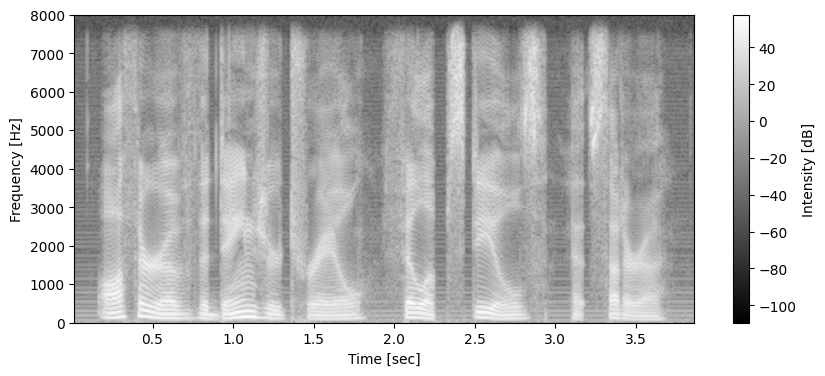

In [13]:
def plot_spectrogram(data, sample_rate):
    """データからスペクトログラムを作成し、それをプロットする関数

    Parameters:
    data: numpy array
        音声データ
    sample_rate: int
        サンプリングレート（Hz）
    """

    # スペクトログラムをプロットする
    fig = plt.figure(figsize=(10, 4))

    # スペクトログラムを表示する
    spectrum, freqs, t, im = plt.specgram(data, NFFT=512, noverlap=int(512 / 16 * 15), Fs=sample_rate, cmap="gray")

    # カラーバーを表示する
    fig.colorbar(im).set_label("Intensity [dB]")

    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")


plot_spectrogram(data, wav.getframerate())

* `specgram` 関数では、関数内で STFT を行っている
* NEET でフレームサイズを指定
* noverlap でオーバーラップ長を指定、細かくするほどスペクトログラムが時間方向に滑らかに表示される
* スペクトログラムを表示する際の各時間の周波数成分の強さ（Intensity）は、デシベル単位で表される
* 次のように対数を取って 20 を掛けたることで、線形の場合と比較してより正確に音声の周波数構造、時間変化の構造を捉えられる$$20 \log_{10} |x_{lk}|$$
* スペクトログラムに変換することで、音声の周波数構造とその時間変化の構造を可視化できる
* 音声分離アルゴリズムを試す中で、どの成分が上手く分離できていないかを確認できる
* アルゴリズムの改善やチューニングを行うときに必須のツール

# 2.4 音声を時間領域の信号に戻す

* ISTFT (Inverse Short Time Fourier Transform: 短時間逆フーリエ変換)：STFT で周波数領域の信号を時間領域の信号に戻す$$y'(l, n) = \frac{1}{N} \sum_{k = 0}^{N - 1} y(l, k) \exp \left( j \frac{2 \pi n k}{N} \right)$$
* 信号は、フレームシフト幅に依存して、フレーム方向にデータが重なっている
* データの重なりを取り、時間領域波形を得るために重畳加算法（Overlap-Add）を用いる

In [14]:
# STFT
f, t, stft_data = sp.stft(data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# ISTFT
t, data_post = sp.istft(stft_data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 2バイトのデータに変換
data_post = data_post.astype(np.int16)

Audio(data=data_post, rate=wav.getframerate())

* `istft` 関数では、関数内で重畳加算も実行
* 返り値は、時間軸の情報と、時間領域の音声信号
* ISTFT で戻した音声は、元の音源とほぼ等しくなることが確認できる

# 2.5 時間周波数領域での音声の加工

## 特定の周波数を消す

* STFT 後の信号 $x(l, k)$ で、特定の周波数よりも高い周波数成分を全て消してみる

In [15]:
# STFT
f, t, stft_data = sp.stft(data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 特定の周波数成分を消す(100番目の周波数よりも高い周波数成分を全て消す)
stft_data[100:, :] = 0
# 時間領域の波形に戻す
t, data_post = sp.istft(stft_data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 2バイトのデータに変換
data_post = data_post.astype(np.int16)

Audio(data=data_post, rate=wav.getframerate())

In [16]:
f[100]

3125.0

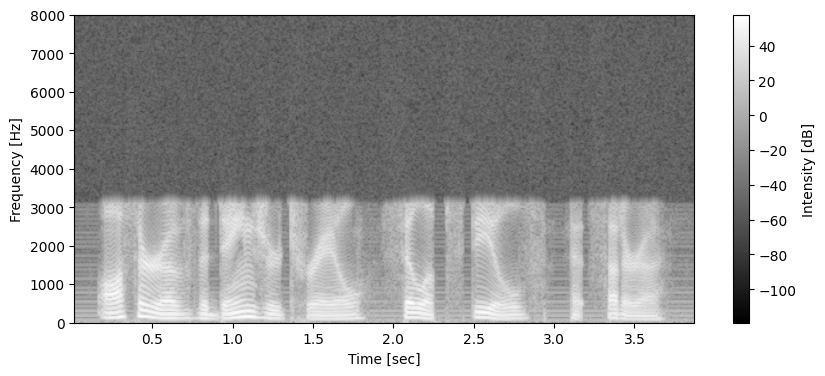

In [17]:
plot_spectrogram(data_post, wav.getframerate())

* こもったような音になる
* 100 番目の周波数が 3125 Hz なので、スペクトログラムでも 3125 Hz よりも高い周波数成分が消えていることが確認できる
* 次は低い周波数を消してみる
* 乾いた音になって、ボリュームも落ちているように感じられる

In [19]:
# STFT
f, t, stft_data = sp.stft(data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 特定の周波数成分を消す(50番目の周波数よりも低い周波数成分を全て消す)
stft_data[:50, :] = 0
print(f[50])
# 時間領域の波形に戻す
t, data_post = sp.istft(stft_data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 2バイトのデータに変換
data_post = data_post.astype(np.int16)

Audio(data=data_post, rate=wav.getframerate())

1562.5


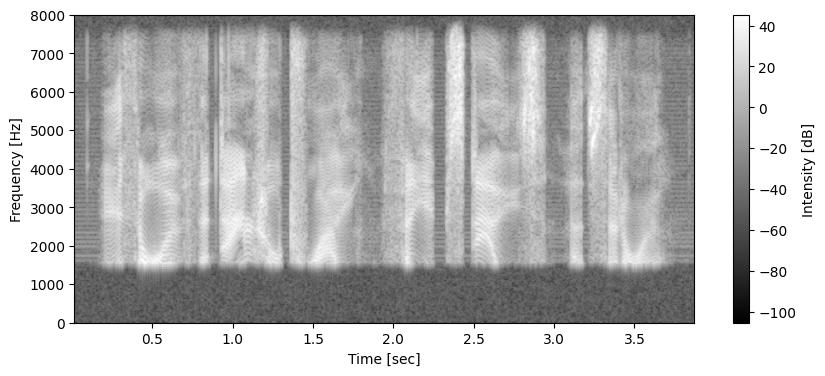

In [20]:
plot_spectrogram(data_post, wav.getframerate())

## 背景の雑音を消す（スペクトルサブトラクション、ウィナーフィルタ）

* 背景の雑音を消す手法を 2 つ試してみる

### スペクトルサブトラクション

* 次のように入力信号成分もしくは音量成分から雑音成分を引き算することで、雑音成分を抑制$$|s_{lk}| = \sqrt[p]{\max \left( |x_{lk}|^p - \alpha |n_{lk}|^p, \epsilon \right)}$$
* $p$ は 1 か 2 に設定するのが一般的
* $\alpha$：スペクトルサブトラクションと呼び、どれくらい雑音を抑圧するかを制御するパラメータ
* $|n_{lk}|$：雑音の振幅で、別途推定しておく
* 雑音だけが存在する時間帯があれば、その時間のマイクロホン入力信号の情報から雑音の振幅を次のように推定できる$$|n_{lk}| = \sqrt[p]{\frac{1}{|\Omega_n|} \sum_{l \in \Omega_n} |x_{lk}|^p}$$
* スペクトルサブトラクション後の信号の位相成分は、入力信号と同じものを用いる$$\hat{s}_{lk} = |s_{lk}| \exp \left( j \phi (x_{lk}) \right) = |s_{lk}| \frac{x_{lk}}{|x_{lk}|}$$

白色雑音を混ぜてノイズ音源を作成

In [21]:
with wave.open(sample_wave_file, "rb") as wav:
    n_speech = wav.getnframes()
    sampling_rate = wav.getframerate()
    speech_signal = wav.readframes(wav.getnframes())
    speech_signal = np.frombuffer(speech_signal, dtype=np.int16)

# 雑音だけの区間のサンプル数を設定
n_noise_only = 40000
# 全体の長さ
n_sample = n_noise_only + n_speech
# 白色雑音を生成
wgn_signal = np.random.normal(scale=0.04, size=n_sample)
# 2バイトのデータとして書き込むためにスケールを調整
wgn_signal = wgn_signal * np.iinfo(np.int16).max
# 2バイトのデータに変換
wgn_signal = wgn_signal.astype(np.int16)

# 白色雑音を混ぜる
mix_signal = wgn_signal
mix_signal[n_noise_only:] += speech_signal

Audio(data=mix_signal, rate=wav.getframerate())

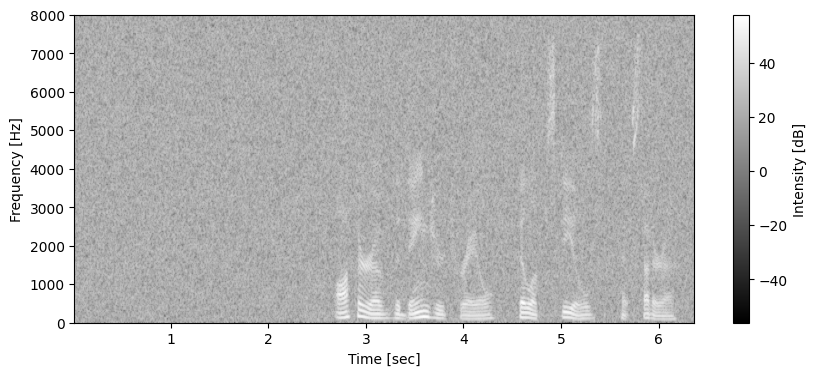

In [22]:
plot_spectrogram(mix_signal, wav.getframerate())

スペクトルサブトラクション

In [23]:
# STFT
f, t, stft_data = sp.stft(mix_signal, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 入力信号の振幅を取得
amp = np.abs(stft_data)
# 入力信号の位相を取得
phase = stft_data / np.maximum(amp, 1.0e-20)
# 雑音だけの区間のフレーム数
n_noise_only_frame = np.sum(t < (n_noise_only / sampling_rate))

# スペクトルサブトラクションのパラメータ
p = 1.0
alpha = 2.0
# 雑音の振幅を推定
noise_amp = np.power(np.mean(np.power(amp, p)[:, :n_noise_only_frame], axis=1, keepdims=True), 1.0 / p)
print(f"{noise_amp.shape = }")

# 入力信号の振幅の1%を下回らないようにする
eps = 0.01 * np.power(amp, p)
print(f"{eps.shape = }")
# 出力信号の振幅を計算する
processed_amp = np.power(np.maximum(np.power(amp, p) - alpha * np.power(noise_amp, p), eps), 1.0 / p)
print(f"{processed_amp.shape = }")
# 出力信号の振幅に入力信号の位相をかける
processed_stft_data = processed_amp * phase
print(f"{processed_stft_data.shape = }")

# ISTFT
t, processed_data_post = sp.istft(processed_stft_data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 2バイトのデータに変換
processed_data_post = processed_data_post.astype(np.int16)

Audio(data=processed_data_post, rate=wav.getframerate())

noise_amp.shape = (257, 1)
eps.shape = (257, 400)
processed_amp.shape = (257, 400)
processed_stft_data.shape = (257, 400)


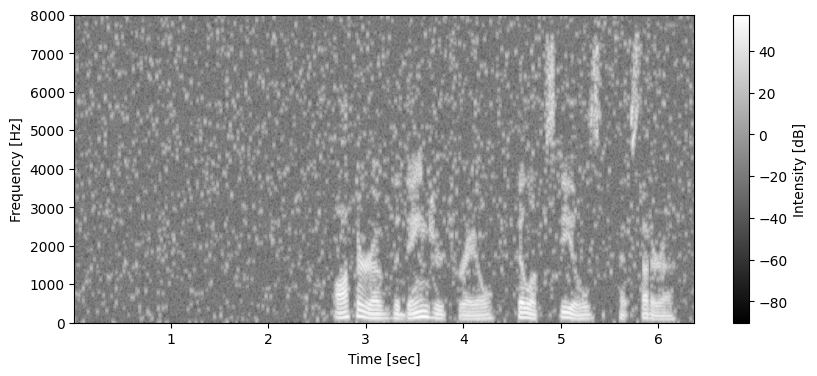

In [24]:
plot_spectrogram(processed_data_post, wav.getframerate())

* 処理前はスペクトログラムが全体的に白く、白色雑音が混じっている
* スペクトルサブトラクション後は、全体的に少し黒に近づき、白色雑音が落ち音声成分が浮き出ている

### ウィナーフィルタ

* 入力信号に実数の係数 $r_{lk}$ を掛けることで、雑音成分を抑制$$\hat{s}_{lk} = r_{lk} x_{lk}$$
* 係数 $r_{lk}$ は、次のように推定する$$r_{lk} = \frac{|s_{lk}|^2}{|s_{lk}|^2 + \mu |n_{lk}|^2}$$
* ここで以下で推定する$$|s_{lk}|^2 = \max \left( |x_{lk}|^2 - \alpha |n_{lk}|^2, \epsilon \right)$$
* $\mu$ を大きい値に設定することで雑音抑圧量を増やすことができる

In [25]:
# 入力信号の振幅を取得
amp = np.abs(stft_data)
# 入力信号のパワーを取得
input_power = np.power(amp, 2.0)
# 雑音だけの区間のフレーム数
n_noise_only_frame = np.sum(t < (n_noise_only / sampling_rate))

# ウィナーフィルタのパラメータ
alpha = 1.0
mu = 10

# 雑音のパワーを推定
noise_power = np.mean(np.power(amp, 2.0)[:, :n_noise_only_frame], axis=1, keepdims=True)
# 入力信号の音量の1%を下回らないようにする
eps = 0.01 * input_power
# 出力信号の振幅を計算する
processed_power = np.maximum(input_power - alpha * noise_power, eps)
# 比率
wf_ratio = processed_power / (processed_power + mu * noise_power)
# 出力信号の振幅に入力信号の位相をかける
processed_stft_data = wf_ratio * stft_data

# 時間領域の波形に戻す
t, processed_data_post = sp.istft(processed_stft_data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)
# 2バイトのデータに変換
processed_data_post = processed_data_post.astype(np.int16)

Audio(data=processed_data_post, rate=wav.getframerate())

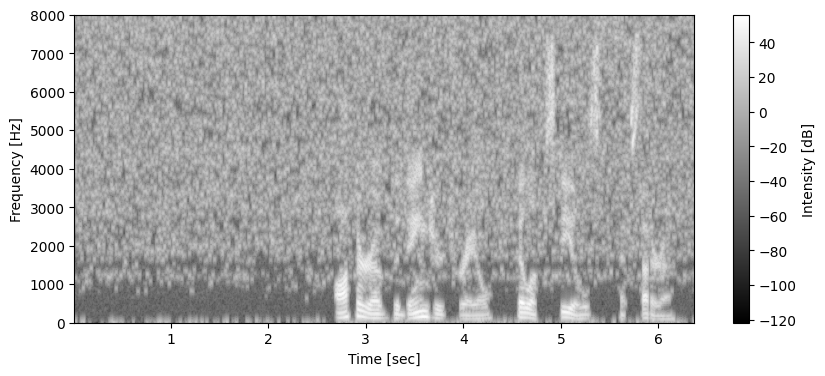

In [26]:
plot_spectrogram(processed_data_post, wav.getframerate())